# Java Development Tools Bug Dataset -  Text Classification (NLP):

Software technology products are often complex and consist of several interacting components. For example, let’s say you are part of a team developing an Android application that plays podcasts. Apart from the player itself, there can be separate components such as the library manager, search and discover, and so on. If a user reports that they are unable to play any podcasts, then it’s important to recognize that this is a critical bug that needs immediate attention. Another user might report an issue with their favorite podcast not showing up. This may not be as critical, but it’s important to determine whether this needs to be looked at by the library manager team or if it’s actually a problem for the search and discover team. To ensure fast response times, it’s important to classify issues accurately and assign them to the right team. Bugs are an inevitable part of any software product, but a quick response will ensure that customers will be happy and continue to use your product.
The JDT project is a part of the Eclipse foundation, which develops the Eclipse integrated development environment (IDE). 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/eclipse_jdt.csv')
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


In [ ]:
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['issue_id', 'priority', 'component', 'duplicated_issue', 'title',
       'description', 'status', 'resolution', 'version', 'created_time',
       'resolved_time'],
      dtype='object')

In [ ]:
df.head()

issue_id priority  ...               created_time              resolved_time
0      1518       P1  ...  2001-10-10 22:14:00 -0400  2001-10-18 11:51:14 -0400
1      1519       P3  ...  2001-10-10 22:14:00 -0400  2001-11-28 13:42:46 -0500
2      1520       P3  ...  2001-10-10 22:14:00 -0400  2002-06-26 11:32:05 -0400
3      1521       P3  ...  2001-10-10 22:14:00 -0400  2002-02-05 10:37:09 -0500
4      1522       P2  ...  2001-10-10 22:14:00 -0400  2001-10-17 10:17:47 -0400

[5 rows x 11 columns]

In [ ]:
df[[
    'issue_id','priority','component',
    'title','description']].sample(5)

issue_id  ...                                        description
15954     46832  ...  Running the test cases for the build input for...
38930    251629  ...  N20081005-2000; ; Paste the following into an ...
5102      13497  ...  Build 20020409; ; When filling in the Main cla...
27524    102609  ...  I NEED SOME HELP IN CODE ASSISt; ; 1)I HAVA A ...
32050    142001  ...  3.2 RC4; In org.eclipse.jdt.internal.compiler....

[5 rows x 5 columns]

### Data Description:

1. **issue_id**: The primary key for the issued.
2. **priority**: This varies from *P1 (most critical)* to *P5 (least critical)* and defines the severity of the bug.
3. **component**: This refers to the specific architechtural part of this project where the bug occurs. This could be UI, the APT etc.
4. **title**: This is short summary entered by the user that briefly describes the bug (a full text field).
5. **description**: This is more detailed description of the software behaviour that produces the bug and its impact on usage (a full text field).

In [ ]:
df.sample().T

11262
issue_id                                                      31559
priority                                                         P3
component                                                        UI
duplicated_issue                                                NaN
title                CVS decoration obscures little fellow [render]
description       The orange barrel decoration on types in the t...
status                                                     RESOLVED
resolution                                                  WONTFIX
version                                                         2.1
created_time                              2003-02-11 11:10:00 -0500
resolved_time                             2004-09-15 13:59:50 -0400

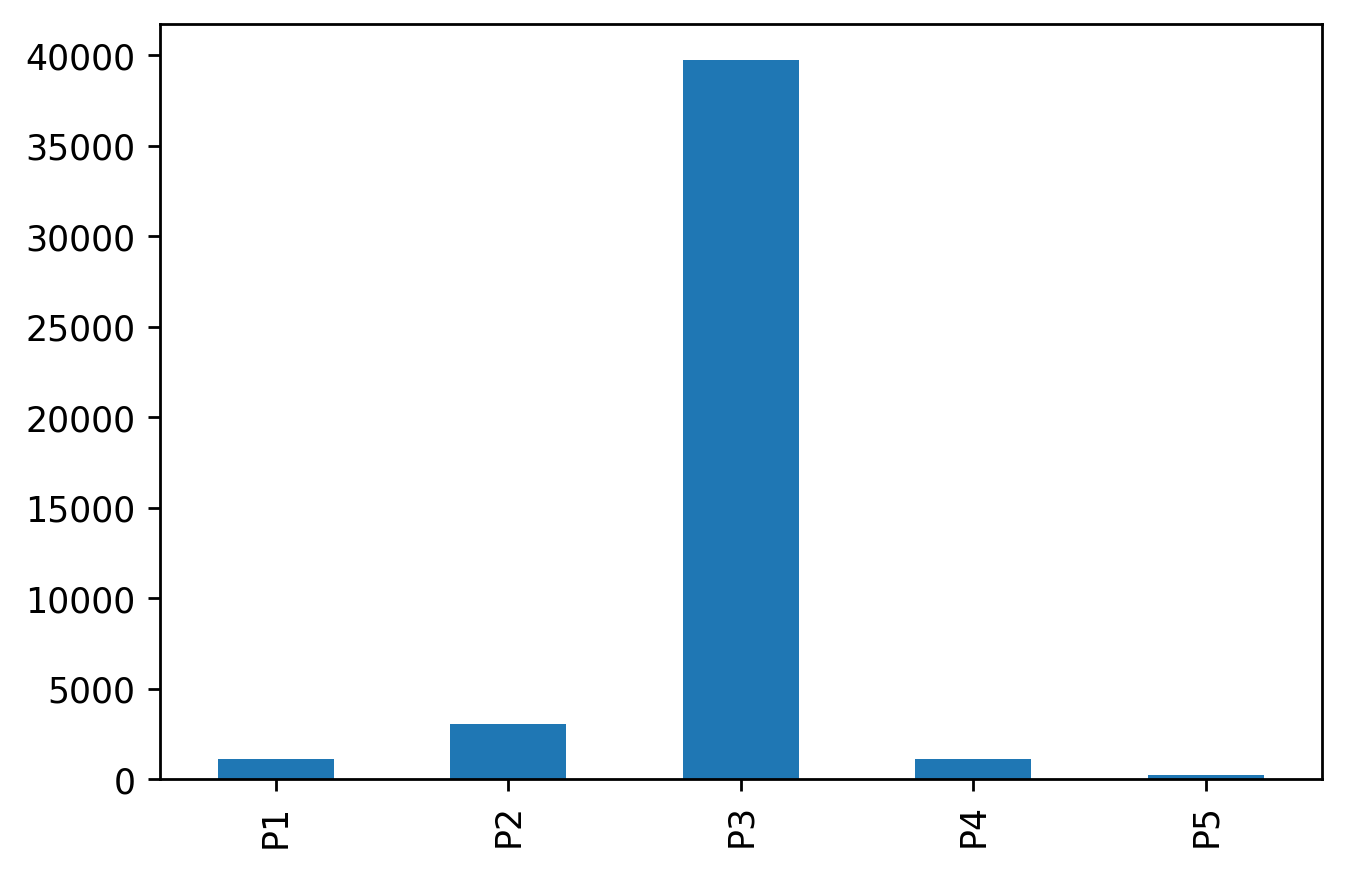

In [ ]:
df['priority'].value_counts().sort_index().plot(kind='bar')

The vast difference between the number of bugs with priority P3 versus other priorities is a problem for building a supervised learning model and is referred to as  class imbalance. Because the class P3 has an order of magnitude greater number of observations than the other classes, the text classification algorithm will have much more information on P3 bugs than the other priorities: P1, P2, P4, and P5.

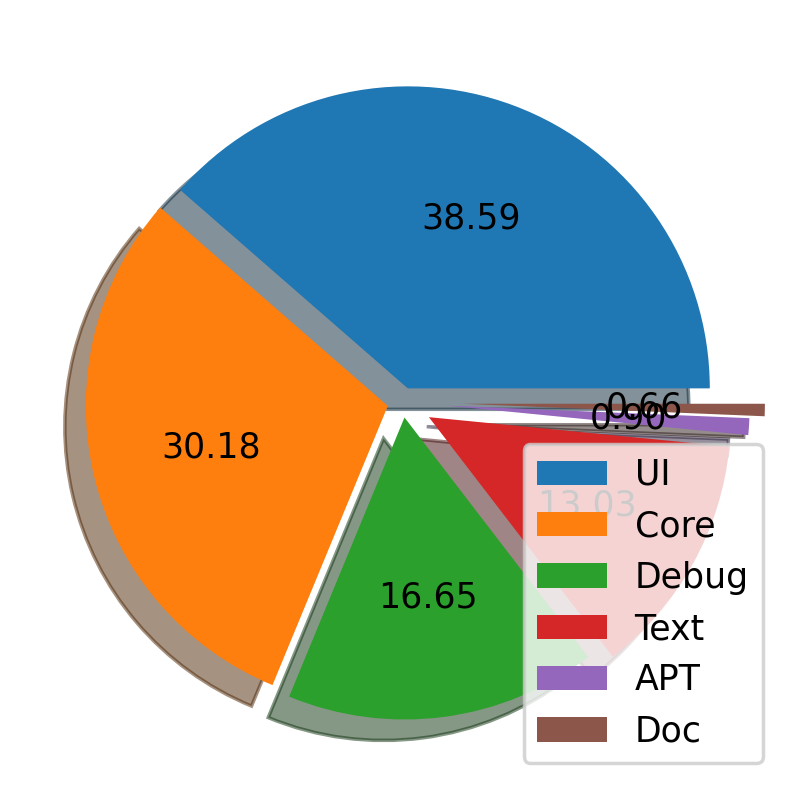

In [ ]:
ui = df['component'].value_counts()['UI']
core = df['component'].value_counts()['Core']
debug = df['component'].value_counts()['Debug']
text = df['component'].value_counts()['Text']
apt = df['component'].value_counts()['APT']
doc = df['component'].value_counts()['Doc']

names = ['UI','Core','Debug','Text','APT','Doc']
values = [ui,core,debug,text,apt,doc]

plt.pie(x=values,autopct='%.2f', shadow=True,
        explode=(0.05,0.05,0.05,0.1,0.15,0.2))
plt.legend(names, loc='lower right')
plt.show()

## Building A Text Classification System:

### Data Preparation:

In [ ]:
df = df[['title','description','priority']]
df = df.dropna()

In [ ]:
df['text'] = df['title'] + ' ' + df['description']
df = df.drop(columns=['title', 'description'])
df.columns

Index(['priority', 'text'], dtype='object')

#### Removing Noise with Regular Expression:

In [ ]:
import html 
import re



def clean(text):
    # convert html escapes like &amp: to character
    text  =  html.unescape(text)
    # tags like <tab>
    text  =  re.sub(r'<[^<>]*>',  ' ',  text)
    # markdow urls like [some text](https://)
    text  =  re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)',  r'\1',  text)
    # text pr code in brackets like [0]
    text  =  re.sub(r'\[[^\[\]]*\]',  ' ',  text)
    # satndalone sequences of special, macthes, &# but not #cool
    text  =  re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)',  ' ',  text)
    # standalone sequences of hyphens like - - - or = = =
    text  =  re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)',  ' ',  text)
    # sequences of white spaces
    text  =  re.sub(r'\s+',  ' ',  text)
    return  text.strip()

In [ ]:
df['text'] = df['text'].apply(clean)


In [ ]:
df = df[df['text'].str.len() > 50]
df.sample(5, random_state=0)

priority                                               text
42439       P3  Regression in TypeHierarchyPerfTest#testOpenOb...
30486       P3  introduce indirection: misleading warning abou...
24663       P3  Source not found Here is a full explanation of...
22899       P3  NPE opening preference page build i1124; ; I g...
1563        P5  Support for lines of code metrics Might be nic...

We can see from the preceding summary of the text feature of bug reports that our cleaning steps have removed a lot of special characters; we still have retained a lot of the code structure and statements that form part of the description. This is useful information that the model can use to understand the bug and will have an impact on whether it belongs to a higher priority.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['priority'], 
       test_size=0.2, random_state=42,
           stratify=df['priority']
)
print(f'Size of Training Data: {X_train.shape[0]}')
print(f'size of Testing Data: {X_test.shape[0]}')

Size of Training Data: 36040
size of Testing Data: 9011


## Support Vector Machines (SVM) - Machine Learning Model:

SVM is popular algorithm for text classification.

Say, we have a set of points X and Y, with each point belonging to one of the two classes. THe SVM works by chooseing a line that clearly separates the two classes.  since, there could be infinite such lines, therefore SVM chooses the line that provides the maximum separtion between the two classes.

Before using the SVM model, the data should be in a form that it can be used by the algorithm. This means the text features needs to be represented in a numerical format.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=10, ngram_range=(1,2), 
        stop_words='english'
)
X_train_tf = tfidf.fit_transform(X_train)

In [ ]:
from sklearn.svm import LinearSVC

model1 = LinearSVC(
    random_state=0, tol=1e-5
)
model1.fit(X_train_tf,y_train)

LinearSVC(random_state=0, tol=1e-05)

### Model Evaluation:

In [ ]:
from sklearn.metrics import accuracy_score

X_test_tf = tfidf.transform(X_test)
y_pred = model1.predict(X_test_tf)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

Accuracy Score: 0.8761513705471091


In [ ]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred_baseline = clf.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_baseline)}')

Accuracy Score: 0.8769281988680502


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model1.predict(X_test_tf)
confusion_matrix(y_test, y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


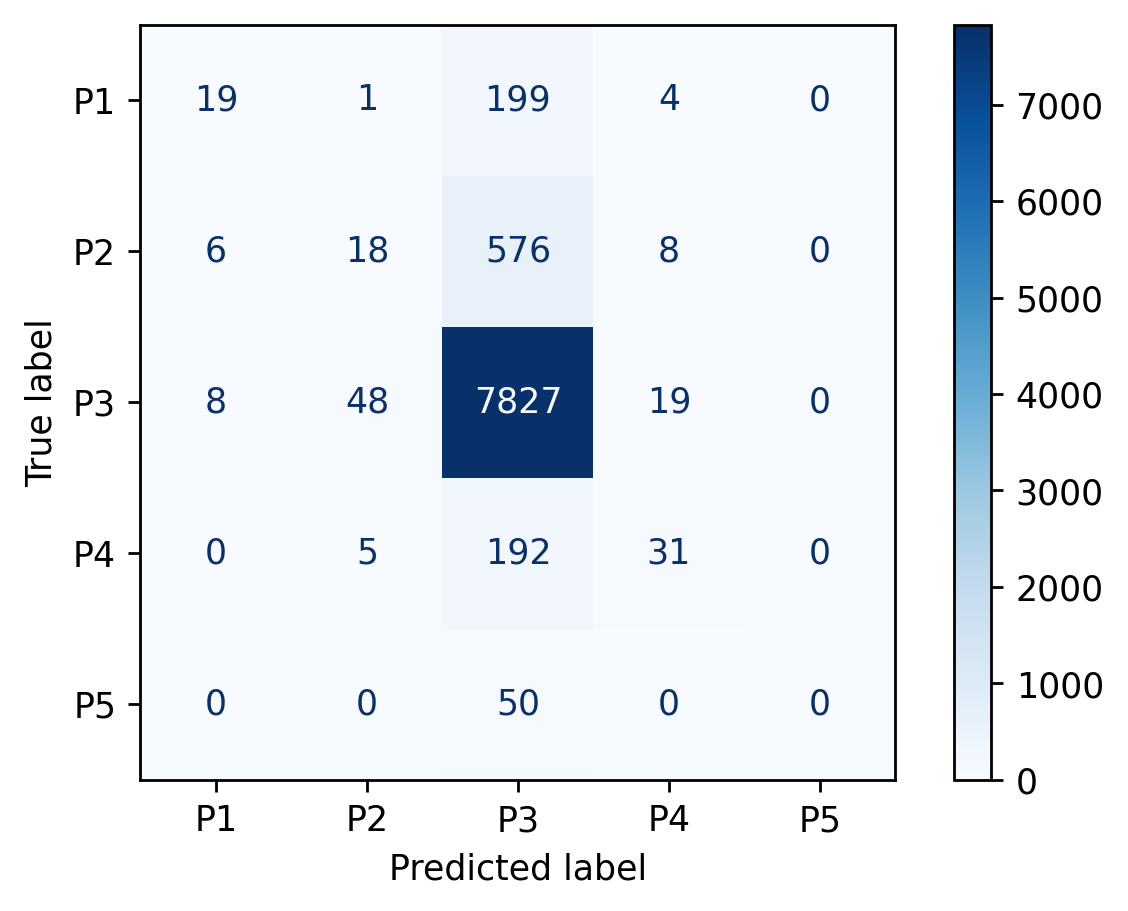

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(
    model1, X_test_tf,
        y_test, values_format='d',
            cmap=plt.cm.Blues  
)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the classification report, one issue arisesm while,recall and precision score for *P3* is very high, these values for other classes are very low and even 0, in some cases of *P5*. The overall accuracy of the model is **88** but if hard_coded the prediction toalways be *P3* this would also fetch **88** accuracy. This makes it clear that the model has not learned much of significance and is merely predicting the majority class.

## Class-Imbalance:

In [ ]:
df_sampleP3 = df[df['priority']=='P3'].sample(n=4000)

In [ ]:
df_sampleRest = df[df['priority'] != 'P3']

In [ ]:
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

In [ ]:
df_balanced['priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: priority, dtype: int64

Generally performing downsampling is not a good idea, since we lose lot of information. However, when we huge class imbalance problem at hand, downsampling, prevemts the model to learn all the right information.

## Final Preparation:

In [ ]:
df = df_balanced[['text', 'priority']]
df = df.dropna()

In [ ]:
df['text'] = df['text'].apply(clean)

In [ ]:
X_train, X_test,y_train,y_test = train_test_split(
    df['text'], df['priority'],
        test_size=0.2, random_state=42,
            stratify=df['priority']
)
print(f'Size of Training Data: {X_train.shape[0]}')
print(f'Size of Test Data: {X_test.shape[0]}')

Size of Training Data: 7636
Size of Test Data: 1909


In [ ]:
tfidf = TfidfVectorizer(
    min_df=10, ngram_range=(1,2),
        stop_words='english'
)
X_train_tf = tfidf.fit_transform(X_train)

In [ ]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, y_train)

LinearSVC(random_state=0, tol=1e-05)

In [ ]:
X_test_tf = tfidf.transform(X_test)
y_pred = model1.predict(X_test_tf)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy Score: 0.5086432687270822
              precision    recall  f1-score   support

          P1       0.49      0.34      0.40       223
          P2       0.44      0.47      0.45       608
          P3       0.57      0.67      0.61       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.51      1909
   macro avg       0.39      0.36      0.37      1909
weighted avg       0.49      0.51      0.50      1909



The model's accuracy is **50%** which is not good. Further, we can see that precision and recall values have improved for priority *P1* and *P2*, indicating that we are able to better predict bugs with this priority. However is's obvious that for bugs with priority *P5* did not imporve at all.

In [ ]:
frame = {
    'text': X_test,
    'actual': y_test,
    'predicted': y_pred
}
result = pd.DataFrame(frame)

In [ ]:
result[
       ((result['actual'] == 'P1') | 
        (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])
].sample(2)

text actual predicted
35700  Duplicate nested type bogus error on static cl...     P1        P3
11582  extract method: extracted method should be pri...     P2        P4

The Model is not accurate. it is clear the relationship between decription and priority exists. Therefore, to improve the model more steps needs to be taken.

## Using Cross- Validation to Estimate Realistic Accuracy Metrics:

In [ ]:
tfidf = TfidfVectorizer(
    min_df=10, ngram_range=(1,2),
       stop_words='english'
)
df_tf = tfidf.fit_transform(df['text']).toarray()

In [ ]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(
    estimator=model1,
    X=df_tf,
    y=df['priority'],
    cv=5
)
print('Validation scores from each iteration fo the cross\
validation', score)
print('Mean value across validation score', score.mean())
print('Standard deviation of validation score', score.std())

Validation scores from each iteration fo the crossvalidation [0.47040335 0.45678366 0.44159246 0.40387638 0.37192247]
Mean value across validation score 0.42891566265060244
Standard deviation of validation score 0.03614898129133237


## Hyperparameter Tuning with Grid Search:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

training_pipeline = Pipeline(
    steps = [('tfidf', TfidfVectorizer(stop_words='english')),
             ('model', LinearSVC(random_state=42, tol=1e-5))]
)

In [ ]:
grid_param = [{
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range':[(1,3),(1,6)],
    'model__penalty':['l2'],
    'model__loss':['hinge'],
    'model__max_iter':[10000]
}, {
    'tfidf__min_df':[5,10],
    'tfidf__ngram_range':[(1,3),(1,6)],
    'model__C':[1,10],
    'model__tol':[1e-2,1e-3]
}]

In [ ]:
gs_processor = GridSearchCV(
    estimator=training_pipeline,
    param_grid = grid_param, cv=5, n_jobs=1
)
gs_processor.fit(df['text'], df['priority'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=42,
                                                  tol=1e-05))]),
             n_jobs=1,
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

In [ ]:
best_params = gs_processor.best_params_
print(f'Best alpha parameter = {best_params}')
best_result = gs_processor.best_score_
print(f'Best result identified = {best_result}')

Best alpha parameter = {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified = 0.4464117338920901


In [ ]:
gs_result = pd.DataFrame(gs_processor.cv_results_)
gs_result[[
           'rank_test_score','mean_test_score',
           'params'
]].sort_values(by=['rank_test_score'])[:5]

rank_test_score  ...                                             params
0                1  ...  {'model__loss': 'hinge', 'model__max_iter': 10...
2                2  ...  {'model__loss': 'hinge', 'model__max_iter': 10...
1                3  ...  {'model__loss': 'hinge', 'model__max_iter': 10...
3                4  ...  {'model__loss': 'hinge', 'model__max_iter': 10...
4                5  ...  {'model__C': 1, 'model__tol': 0.01, 'tfidf__mi...

[5 rows x 3 columns]

In [ ]:
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/eclipse_jdt.csv')

In [ ]:
df = df[['Title','Description','Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Component']
df = df.drop(columns=['Title', 'Description'])

In [ ]:
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

In [ ]:
runSVC = True

if (runSVC):
    df = df.groupby('Component',
            as_index=False).apply(
                pd.DataFrame.sample,
            random_state=21, frac=0.2
            )

In [ ]:
X_train,X_test, y_train,y_test = train_test_split(
    df['text'], df['Component'], test_size=0.2,
    random_state=42, stratify = df['Component']
)

In [ ]:
print(f'Size of Training Data: {X_train.shape[0]}')
print(f'Size of Test Data: {X_test.shape[0]}')

In [ ]:
if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df':[5,10],
        'tfidf__ngram_range':[(1,3),(1,6)],
        'model__C':[1,100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param= {
        'tfidf__min_df': [5,10],
        'tfidf__ngram_range': [(1,3),(1,6)],
        'model__C':[1,100],
        'model__loss':['hinge']
    }

In [ ]:
training_pipeline = Pipeline(
    steps=[('tfidf',TfidfVectorizer(
        stop_words='english'
    )), ('model', model)]
)
gs_processor = GridSearchCV(
    estimator=training_pipeline, 
    param_grid=grid_param, cv=5, n_jobs=1
)
gs_processor.fit(X_train,y_train)

In [ ]:
best_params = gs_processor.best_params_
print('Best alpha parameter', best_params)
best_result = gs_processor.best_score_
print('Best result identified', best_result)

In [ ]:
best_model = gs_processor.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Based on the accuracy and classification report, the model has raked up accuracy from 45% to 74%, now we can say something about the model, that it can predict the softwarre component that bug is referring to more accurately than the priority.

In [ ]:
frame  =  {  
    'text': X_test, 
    'actual':  y_test,
      'predicted':  y_pred
} 
result  =  pd.DataFrame(frame)

In [ ]:
result[result['actual']==result['predicted']].sample(5)

text actual predicted
44701  Usability: auto completion does not clearly hi...     P3        P3
9732   Code Formatter Wont Indent Braces I want my co...     P3        P3
3859   Code assist failed with cursor before string s...     P2        P2
11376  Override methods inserts code with compile err...     P4        P4
16934  KVM: stepping with this expanded When I expand...     P3        P3

In [ ]:
result[result['actual']!=result['predicted']].sample(5)

text actual predicted
3703   Remote Debugger Doesnt Attach To Processes Hi;...     P1        P3
4718   Extensible remote connection type A new extens...     P2        P3
18413  processors should complete their modification ...     P2        P3
252    Core error compiling a java class (1GEJK8Q) 0)...     P3        P1
34888  breakpoint performance tests The peformance te...     P1        P2

While the model's accuracy has increased, the model does classify some accurately and some inaccurately. Therefore, analysing the feature which are responsible for for the said prediction of the model.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/eclipse_jdt.csv',)

In [ ]:
df = df.groupby('Component', as_index=False,
    ).apply(
        pd.DataFrame.sample, random_state=42, frac=.2        
                )


In [ ]:
df = df[['Title',
         'Description',
         'Component']]
df = df.dropna()
df['text'] = df['Title'] + ' '+ df['Description']
df = df.drop(columns=['Title', 'Description']) 

In [ ]:
df['text'] = df['text'].apply(clean)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['Component'], 
    test_size=0.2, random_state=42,
    stratify=df['Component']
)

In [ ]:
tfidf = TfidfVectorizer(
    min_df=10, ngram_range=(1,2),
    stop_words='english',
)
X_train_tf = tfidf.fit_transform(X_train)

In [ ]:
svc = SVC(
    kernel='linear', C=1,
    probability=True, random_state=42
)
svc.fit(X_train_tf, y_train)

SVC(C=1, kernel='linear', probability=True, random_state=42)

In [ ]:
X_test_tf = tfidf.transform(X_test)
y_pred = svc.predict(X_test_tf)

In [ ]:
result = pd.DataFrame(
    {'text':X_test.values,
     'actual':y_test.values,
     'predicted':y_pred
    }
)
result[result['actual'] != result['predicted']].head()

text actual predicted
2   NPE in Delta processor while executing JDT/UI ...   Core        UI
15  Inserting a block of text in editor badly alig...     UI      Text
16  Differences when debugging identical objects W...  Debug      Core
20  Foreach template doesnt work for class members...   Core        UI
22  NPE while copy variables in Variables view Err...    APT     Debug

In [ ]:
text = result.iloc[2]['text']
print(text)

NPE in Delta processor while executing JDT/UI tests Build input for I20030617; ; Got the following NPE while executing the JDT/UI tests; ; !ENTRY org.eclipse.core.resources 4 2 Jun 17; 2003 12:38:38.578; !MESSAGE Problems occurred when invoking code from plug-; in: org.eclipse.core.resources.; !STACK 0; java.lang.NullPointerException; at org.eclipse.jdt.internal.core.DeltaProcessor.resourceChanged; (DeltaProcessor.java(Compiled Code)); at org.eclipse.core.internal.events.NotificationManager$1.run; (NotificationManager.java(Compiled Code)); at org.eclipse.core.internal.runtime.InternalPlatform.run; (InternalPlatform.java(Compiled Code)); at org.eclipse.core.runtime.Platform.run(Platform.java(Inlined Compiled ; Code)); at org.eclipse.core.internal.events.NotificationManager.notify; (NotificationManager.java(Compiled Code)); at org.eclipse.core.internal.events.NotificationManager.broadcastChanges; (NotificationManager.java(Compiled Code)); at org.eclipse.core.internal.resources.Workspace.

In [ ]:
svc.predict_proba(X_test_tf[2])

array([[0.00296779, 0.41605781, 0.05542103, 0.00179552, 0.01254439,
        0.51121346]])

Remembering that the classes had the order APT, Core, Debug,  Doc, Text, and UI, the algorithm was a bit more convinced of Core compared to UI, which would have been its second choice.

In [ ]:
class_names = ['APT','Core','Debug',
               'Doc','Text','UI']
prob = svc.predict_proba(X_test_tf)
er = result.copy().reset_index()
for i,c in enumerate(class_names):
    er[c] = prob[:,i]

In [ ]:
er[['actual', 'predicted'] + \
   class_names].sample(5, random_state=21)

actual predicted       APT  ...       Doc      Text        UI
666    Core      Core  0.000867  ...  0.000199  0.015684  0.179279
1264     UI        UI  0.002009  ...  0.003312  0.007734  0.920995
1536   Core      Core  0.002566  ...  0.002172  0.017650  0.111503
648    Core      Core  0.000649  ...  0.000758  0.134027  0.058367
436    Text      Core  0.002162  ...  0.000701  0.033176  0.215655

[5 rows x 8 columns]

In [ ]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong = (er[er['actual'] != er['predicted']])

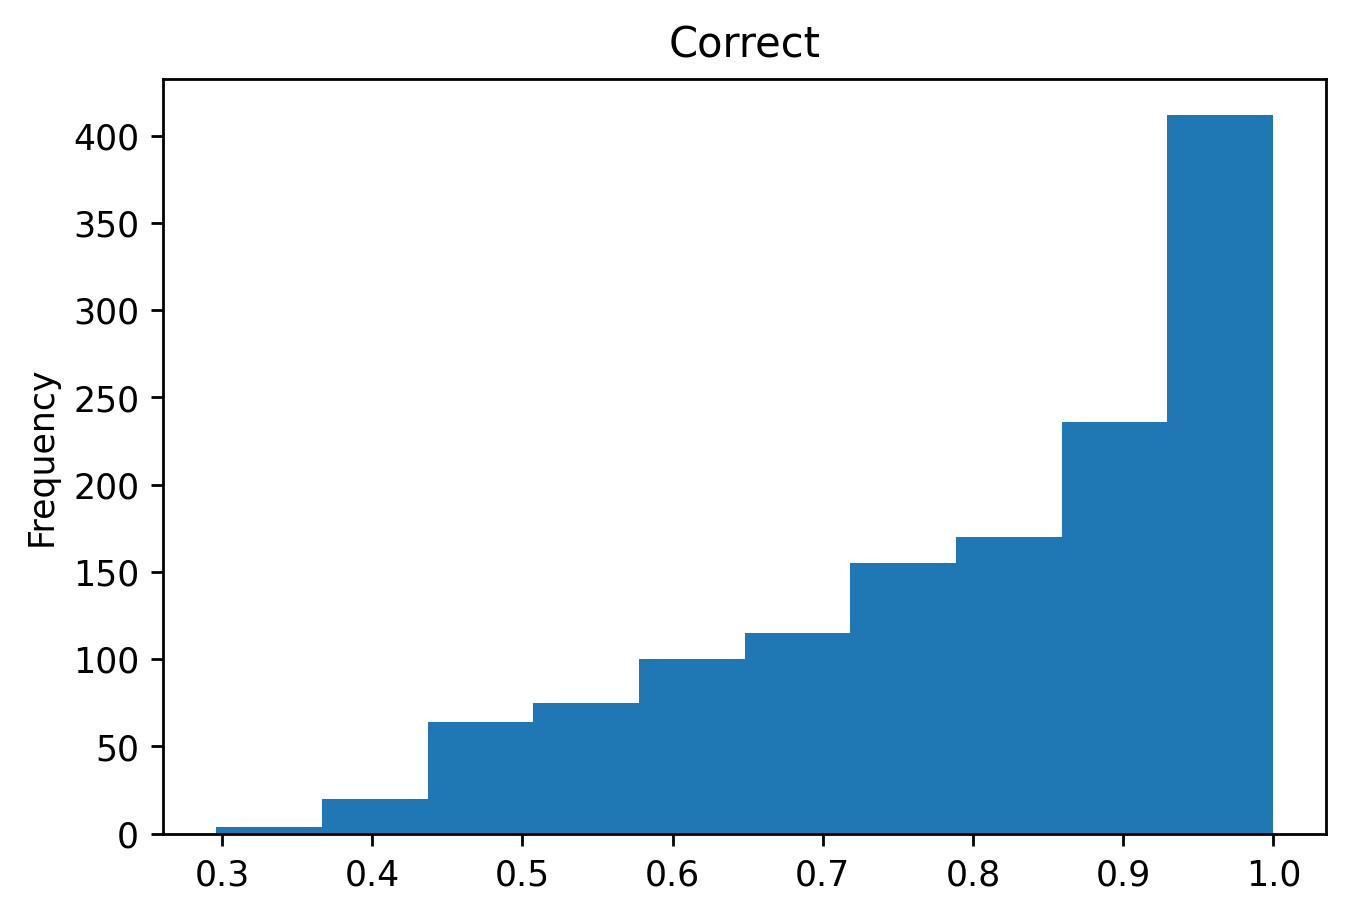

In [ ]:
correct['max_probability'].plot.hist(title='Correct')

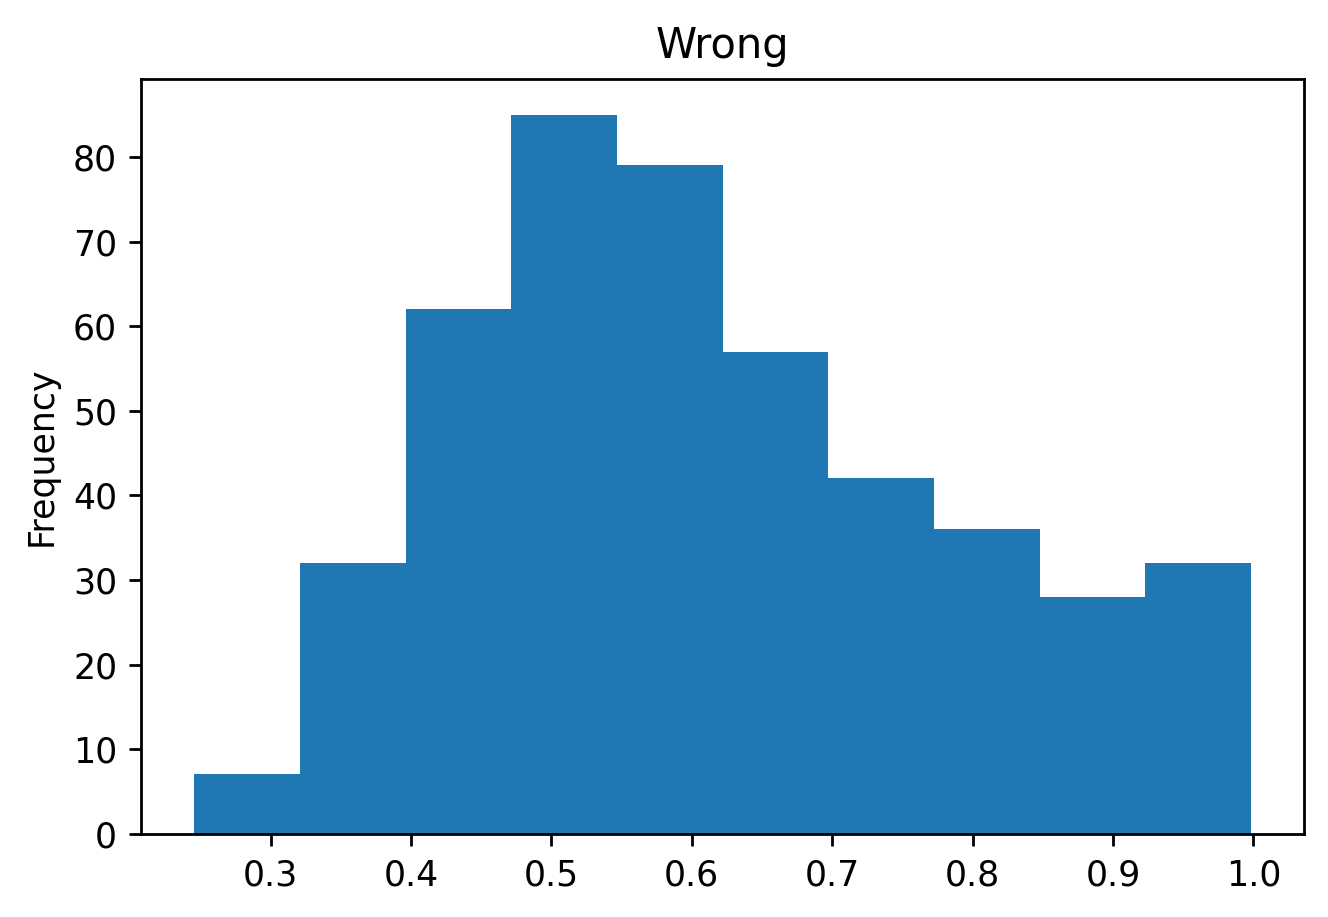

In [ ]:
wrong['max_probability'].plot.hist(title='Wrong')

In [ ]:
high = er[er['max_probability'] > 0.75]
print(classification_report(high['actual'],
                high['predicted']))
print('--'*40)
print('Comparing with original result')
print('--'*40)
print(classification_report(er['actual'],
                er['predicted']))

              precision    recall  f1-score   support

         APT       0.90      0.75      0.82        12
        Core       0.92      0.88      0.90       306
       Debug       0.93      0.98      0.96       207
         Doc       1.00      0.67      0.80         3
        Text       0.74      0.73      0.74        88
          UI       0.89      0.91      0.90       403

    accuracy                           0.90      1019
   macro avg       0.90      0.82      0.85      1019
weighted avg       0.90      0.90      0.90      1019

--------------------------------------------------------------------------------
Comparing with original result
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         APT       0.90      0.56      0.69        16
        Core       0.75      0.77      0.76       546
       Debug       0.89      0.77      0.82       302
         Doc       1.00      0.25      0.40    

We can see that we have considerably improved the precision for predicting the components Core, Debug, Text, and UI while at the same time increasing the recall. This is great, as the explanation of the SVM has led us to a smaller subset of data in which the classifier works better. However, in the components with few samples (Apt, Doc), the result has actually only improved the recall. It seems that there are just too few samples in these categories, and the algorithm has too little information to decide
based on the text. In the case of Doc, we just removed most of the documents belonging to this class and so increased the recall.


The improvement came with a price, though. We have excluded more than 900 documents, roughly half of the dataset. So, overall, we have actually found fewer documents in the smaller dataset! In some projects, it might be useful to let the model only decide in cases where it is quite “sure” and discard ambiguous cases (or classify them by hand). This often depends on the business requirements.

## Measuring Feature Importtance of Predictive MDeol:

In [ ]:
svc.coef_

<15x9441 sparse matrix of type '<class 'numpy.float64'>'
	with 93970 stored elements in Compressed Sparse Row format>

In [ ]:
coef = svc.coef_[8].A[0]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [ ]:
core_ui = pd.DataFrame(
    [[vocabulary[c],coef[c]] for c in \
        top_positive_coef + top_negative_coef],
           columns=['feature','coefficient']
).sort_values('coefficient')

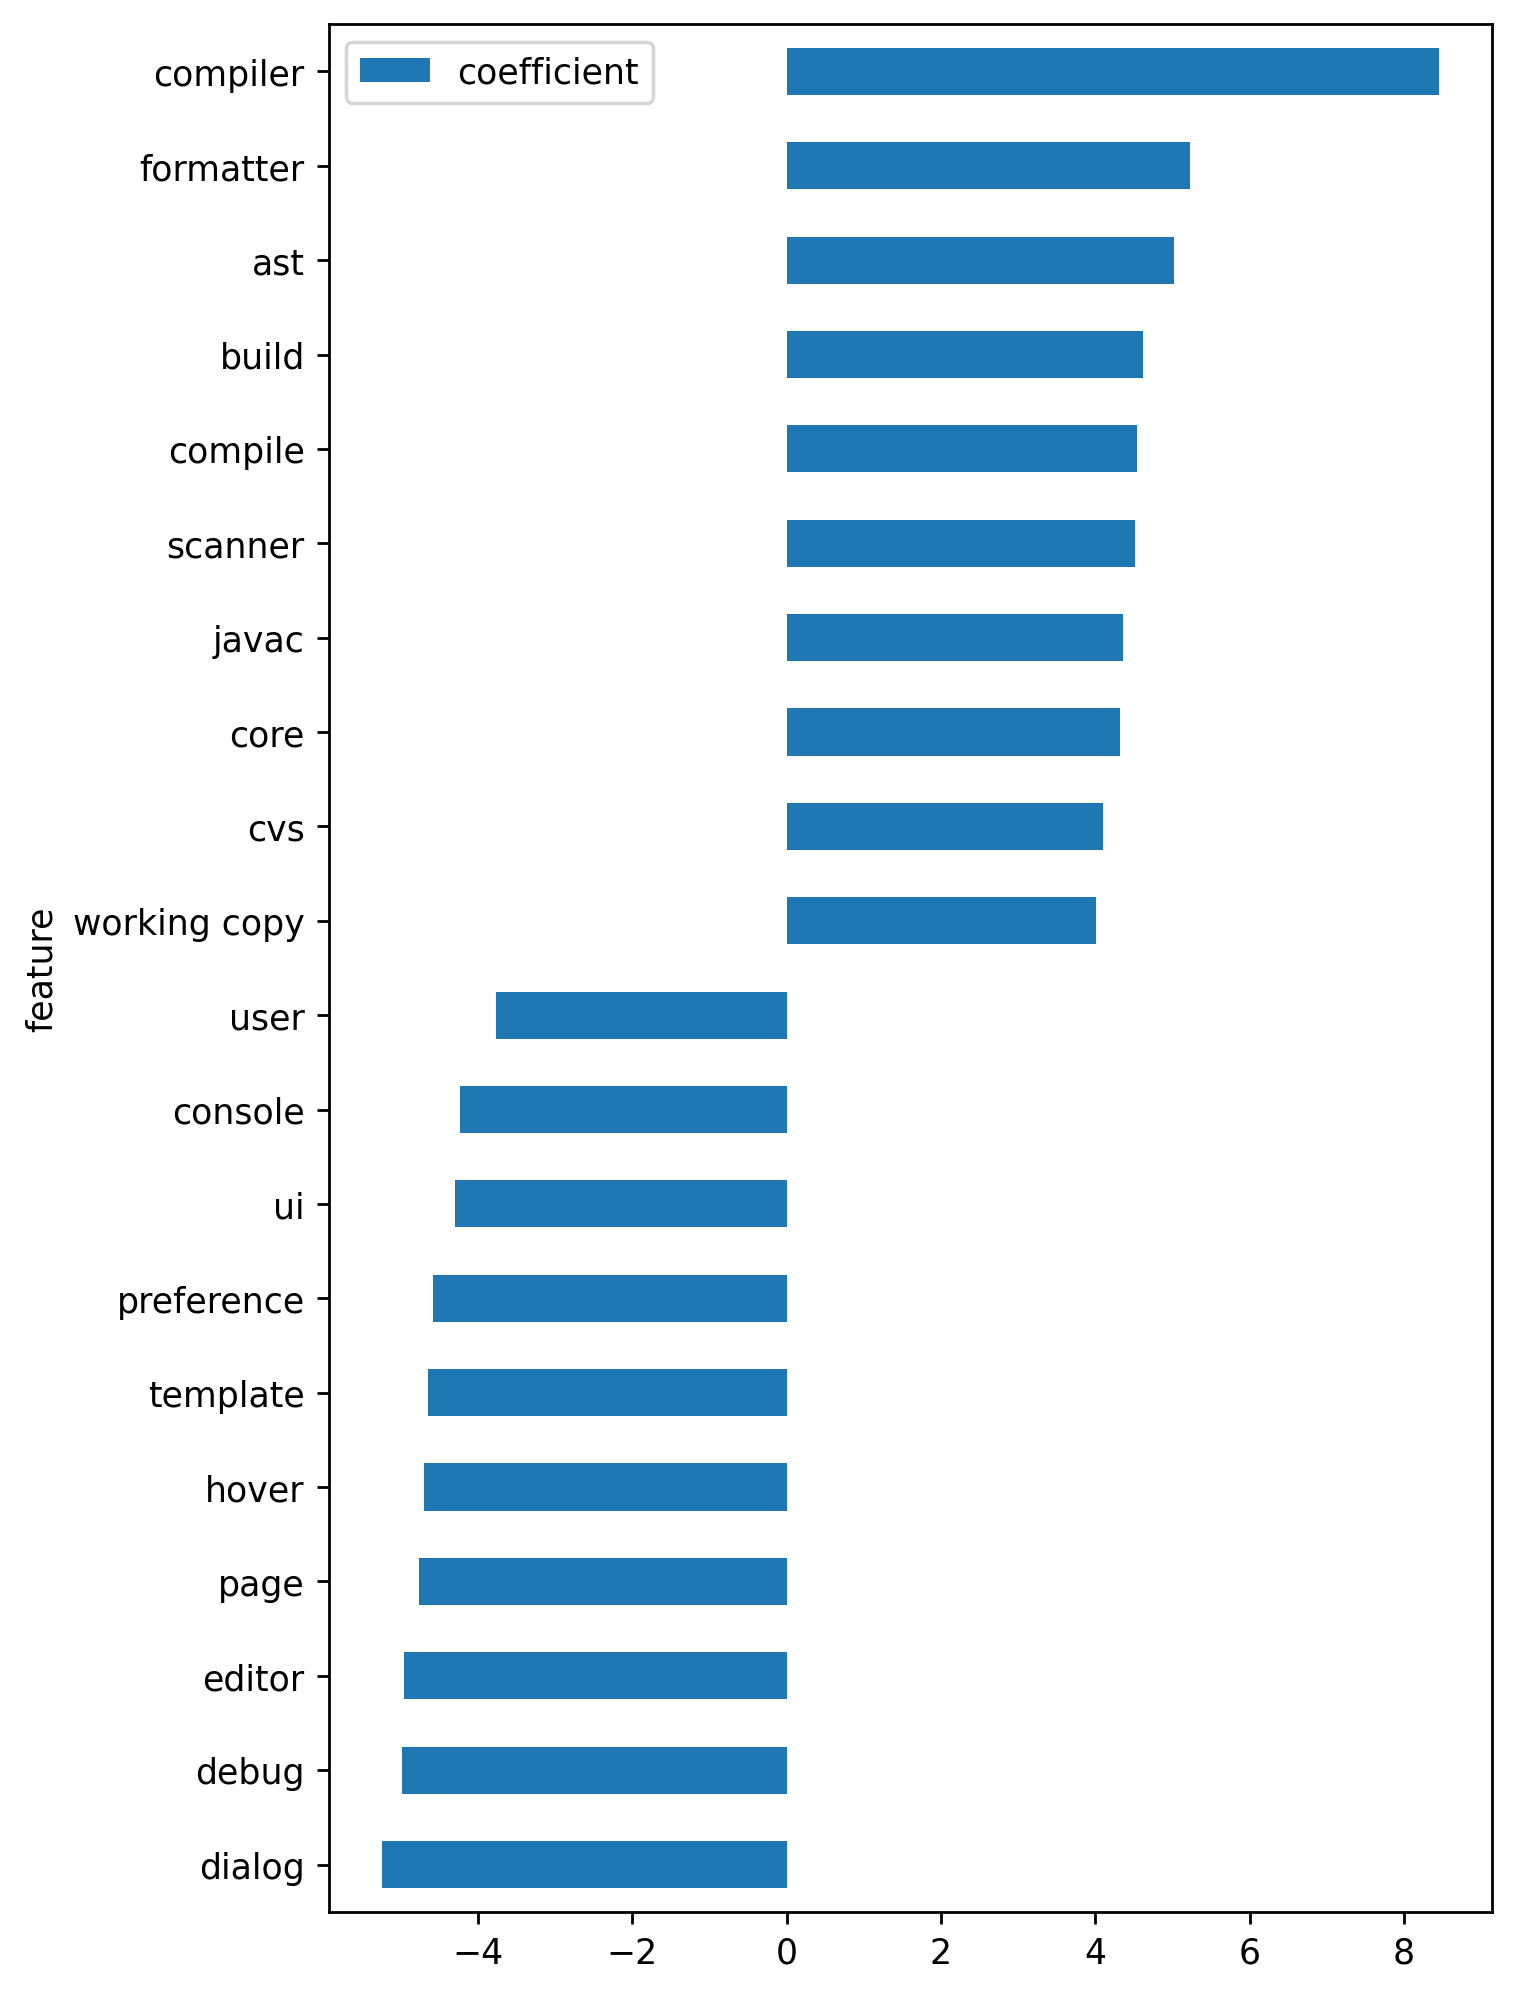

In [ ]:
core_ui.set_index('feature').plot.barh(figsize=(6,10),)

## Using LIME to Explain the Classification Results:

In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(tfidf, svc)
pipeline.predict_proba(['compiler not working'])

array([[0.00339929, 0.95967605, 0.00200337, 0.00102722, 0.01025551,
        0.02363856]])

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
er[er['predicted'] !=er['actual']].head()

index  ... max_probability
2       2  ...        0.511213
15     15  ...        0.631444
16     16  ...        0.397455
20     20  ...        0.812737
22     22  ...        0.787536

[5 rows x 11 columns]

In [ ]:
id = 20
print('Document id: %d' %id)
print('Predicted class =', er.iloc[id]['predicted'])
print('True class: %s' % er.iloc[id]['actual'])

Document id: 20
Predicted class = UI
True class: Core


In [ ]:
exp = explainer.explain_instance(
    result.iloc[id]['text'],
    pipeline.predict_proba, num_features=10,
    labels=[1,5]
)
print('Explaination for class %s' % class_names[1])
print('\n'.join(map(str, exp.as_list(label=1))))
print('Explanation for class %s' % class_names[5])
print('\n'.join(map(str, exp.as_list(label=5))))

Explaination for class Core
('template', -0.2999750211032073)
('members', -0.16288510737697687)
('following', 0.04350395456549746)
('public', 0.0409396347711968)
('code', 0.0336103714302732)
('method', -0.0284090930094031)
('used', 0.025917821349403524)
('guess', 0.023497627548088554)
('scope', 0.02206051340961138)
('work', -0.012591749749951538)
Explanation for class UI
('members', 0.19604360418671288)
('doesnt', 0.1413200087274208)
('method', 0.05810776064681189)
('test', 0.054956008376835674)
('following', -0.041251937555949254)
('template', 0.03914375180873672)
('private', 0.034838583443519006)
('scope', -0.03090516456821125)
('code', -0.025973459867808055)
('Example', -0.02413564789533586)


In [ ]:
exp = explainer.explain_instance(
    result.iloc[id]['text'], 
    pipeline.predict_proba, num_features=6, top_labels=3
)
exp.show_in_notebook(text=False)

In [ ]:
from lime import submodular_pick
import numpy as np

np.random.seed(42)
lsm = submodular_pick.SubmodularPick(
    explainer, er['text'].values,
    pipeline.predict_proba,
    sample_size=100,
    num_features=20,
    num_exps_desired=5
)
lsm.explanations[0].show_in_notebook()

## Using ELI5 to Explain the Classification Results:

In [ ]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', max_iter=1000,
                    tol=1e-5, random_state=42)
svm.fit(X_train_tf, y_train)
y_pred_svm = svm.predict(X_test_tf)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         APT       0.82      0.56      0.67        16
        Core       0.77      0.76      0.76       546
       Debug       0.86      0.83      0.85       302
         Doc       0.67      0.33      0.44        12
        Text       0.61      0.57      0.59       236
          UI       0.76      0.80      0.78       699

    accuracy                           0.76      1811
   macro avg       0.75      0.64      0.68      1811
weighted avg       0.76      0.76      0.76      1811

